In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

In [2]:
#import matrix

mat = loadmat("ex3data1.mat")
X = mat["X"]
y = mat["y"]

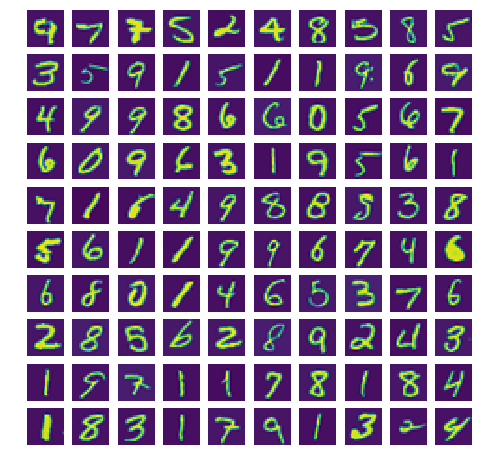

In [3]:
fig,axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5000),:].reshape(20,20,order="F"))
        axis[i,j].axis("off")

In [4]:
# sigmoid function

def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
# Derivative of sigmoid function

def sigmoidGradient(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [6]:
# number of elements of layer size (camada de entrada)
# number of elements of hidden layer
# number of elements of output: num_labels

def computeCost(X,y,theta,input_layer_size, hidden_layer_size, num_labels, Lambda):
    
    m = X.shape[0]
    # number of layers
    if type(theta)==int:
        l=1
    else:   
        l=len(theta)
    J = 0
    #join the vector of 1s
    X = np.hstack((np.ones([m,1]),X))
    y10 = np.zeros([m,num_labels])
    
    #1st activation list
    a=[]

    for i in range(l):
        #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)
       
        #final activation
        elif i==l-1:
            a2 = sigmoid(a[i-1] @ theta[i].T)
            a.append(a2)
            
        #hidden activation
        else:
            a1 = sigmoid(a[i-1] @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)

                
    for i in range(1,num_labels+1):
        #creates the matrix of ys, where each column is the vector of label, with 1 in position i if class=i
    
        ''' np.newaxis might come in handy when you want to explicitly convert a 1D array to 
            either a row vector or a column vector.
        '''
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        
    for j in range(num_labels):
        #adding all log cost function
        J = J - np.sum(y10[:,j]*np.log(a[l-1][:,j])+(1-y10[:,j])*np.log(1-a[l-1][:,j]))
        
    cost = (1/m)*J
    
    #regularized cost for logistic regression
    regj = 0
    # derivatives for each layer  
    grad = []
    for i in range(l):
        regj = regj+np.sum(theta[i][:,1:]**2)   ####CHECK IF IT CAN BE CHANGED TO DOT PRODUCT.
        grad.append(np.zeros((theta[i].shape)))
      
    reg_J = cost + Lambda/(2*m)*(regj)
            
    #compute updating of thetas
    for i in range(m):
        xi = X[i,:]
        
        #activacao i
        ai= []
        ai.append(xi)
        
        for j in range(l):
            ai.append(a[j][i,:])
       
        # deltas 
        delta = []
        #len(ai)=l+1
        for j in range(l,0,-1):
            # delta in output
            if j==l:
                # 1st delta
                delta.append(ai[j]-y10[i,:])
            
            #delta hidden layer
            
            #the case of layer L-1 is different because of bias on L-1 and not bias on output
            elif j==l-1:
                delta.append((theta[j].T @ delta[l-j-1])*(ai[j])*(1-ai[j]))
            
            else: 
                #never delta(0)
                delta.append((theta[j].T @ delta[l-j-1][1:])*(ai[j])*(1-ai[j]))
        
        # reverse delta because it's created by backpropagation
        delta.reverse()
     
        # grad = grad anterior(layer l) + delta(layer l+1)*(a(layer l))^T 
        
        #update grad
        
        for j in range(l):
            # recall ai[j] = a[j-1]... len(ai)=l+1 because a1[0]=xi
            if j==l-1:
                grad[j] = grad[j] +  delta[j].T[:,np.newaxis]@ai[j][:,np.newaxis].T
            else:
                grad[j] = grad[j] + delta[j][1:][:,np.newaxis]@ ai[j][:,np.newaxis].T

    grad_reg = []

    for i in range(l):
        grad[i] = (1/m)*grad[i]
        grad_reg.append(grad[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]), theta[i][:,1:])))
    
    # now, we need to regularize the derivatives
#     for i in range(l):
#         grad_reg.append(grad[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]), theta[i][:,1:])))
    
    
    return cost, grad, reg_J,grad_reg

In [7]:
#initialize weights

def randInitializeWeights(L_in,L_out):
    epi = (2**(1/2))/(L_in+L_out)**(1/2)
    # Recall the matrix is like in the other sense and we need to add the bais weight
    W = np.random.rand(L_out,L_in+1)*(2*epi)-epi
    return W

In [8]:
# gradient descent 

def gradientDescent(X,y,theta,alpha,n_iter, Lambda, input_layer_size, hidden_layer_size,num_labels):
    #input_layer_size+1 because od bias
#     theta1 = theta[:((input_layer_size+1)*hidden_liyer_size)].reshape(hidden_layer_size, input_layer_size+1)
#     theta2 = theta[((input_layer_size+1)*hidden_liyer_size):].reshape(num_labels, hidden_layer_size+1)
    
    l=len(theta)
    m = len(y)
    J_history = []
    
    theta_fin = theta
    
    for i in range(n_iter):
        #theta = np.append(theta1.flatten(),theta2.flatten())
        #to take the regularized cost and reg gradients
        cost, grad = computeCost(X,y,theta_fin, input_layer_size,hidden_layer_size,num_labels,Lambda)[2:]
        for j in range(l):
            theta_fin[j] = theta_fin[j]-(alpha*grad[j])        
        J_history.append(cost)
    
    return theta_fin,J_history

In [9]:
def prediction(X, theta):
    l=len(theta)
    m = X.shape[0]
    X = np.hstack((np.ones([m,1]),X))
    
#     a = []

    
#     for i in range(l):
#     #1st activation
#         if i==0:
#             a1 = sigmoid(X @ theta[i].T)
#             a1 = np.hstack((np.ones([m,1]),a1))
#             a.append(a1)

#         #final activation
#         elif i==l-1:
#             a2 = sigmoid(a[i-1] @ theta[i].T)
#             a.append(a2)

#         #hidden activation
#         else:
#             a1 = sigmoid(a[i-1] @ theta[i].T)
#             a1 = np.hstack((np.ones([m,1]),a1))
#             a.append(a1)
            
    for i in range(l):
    #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))

        #final activation
        elif i==l-1:
            a2 = sigmoid(a1 @ theta[i].T)

        #hidden activation
        else:
            aux=a1
            a1 = sigmoid(aux @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
    

    # the class is the largest value
    return np.argmax(a2,axis=1)+1

In [10]:
# creates the initial theta according to initial layer size, hidden layer size and number of labels

def initialTheta(input_layer_size, hidden_layer_size,num_labels):
    theta = []
    if type(hidden_layer_size)== int:
        theta.append(randInitializeWeights(input_layer_size,hidden_layer_size))
        theta.append(randInitializeWeights(hidden_layer_size,num_labels))
    else:
        k = len(hidden_layer_size)
        for i in range(k+1):
            if i==0:
                theta.append(randInitializeWeights(input_layer_size, hidden_layer_size[0]))
            elif i== k:
                theta.append(randInitializeWeights(hidden_layer_size[k-1], num_labels))
            else:
                theta.append(randInitializeWeights(hidden_layer_size[i-1],hidden_layer_size[i]))
    return theta
            
    

In [11]:
## Initialize

input_layer_size = 400
# list of hidden layers'size
hidden_layer_size = 25
num_labels = 10

Lambda = 1

initial_theta = initialTheta(input_layer_size,hidden_layer_size,num_labels)

In [12]:
# Gradient Descent 

theta, J_history = gradientDescent(X,y, initial_theta, 0.8,50, Lambda,input_layer_size, hidden_layer_size, num_labels)


In [13]:
def scalingMatrix(X):
    Z = (X.min())*np.ones(X.shape)
    newX = (1/(X.max()-X.min()))*(X - Z)
    return(newX)    

### Visual representation for each activation function on first layer

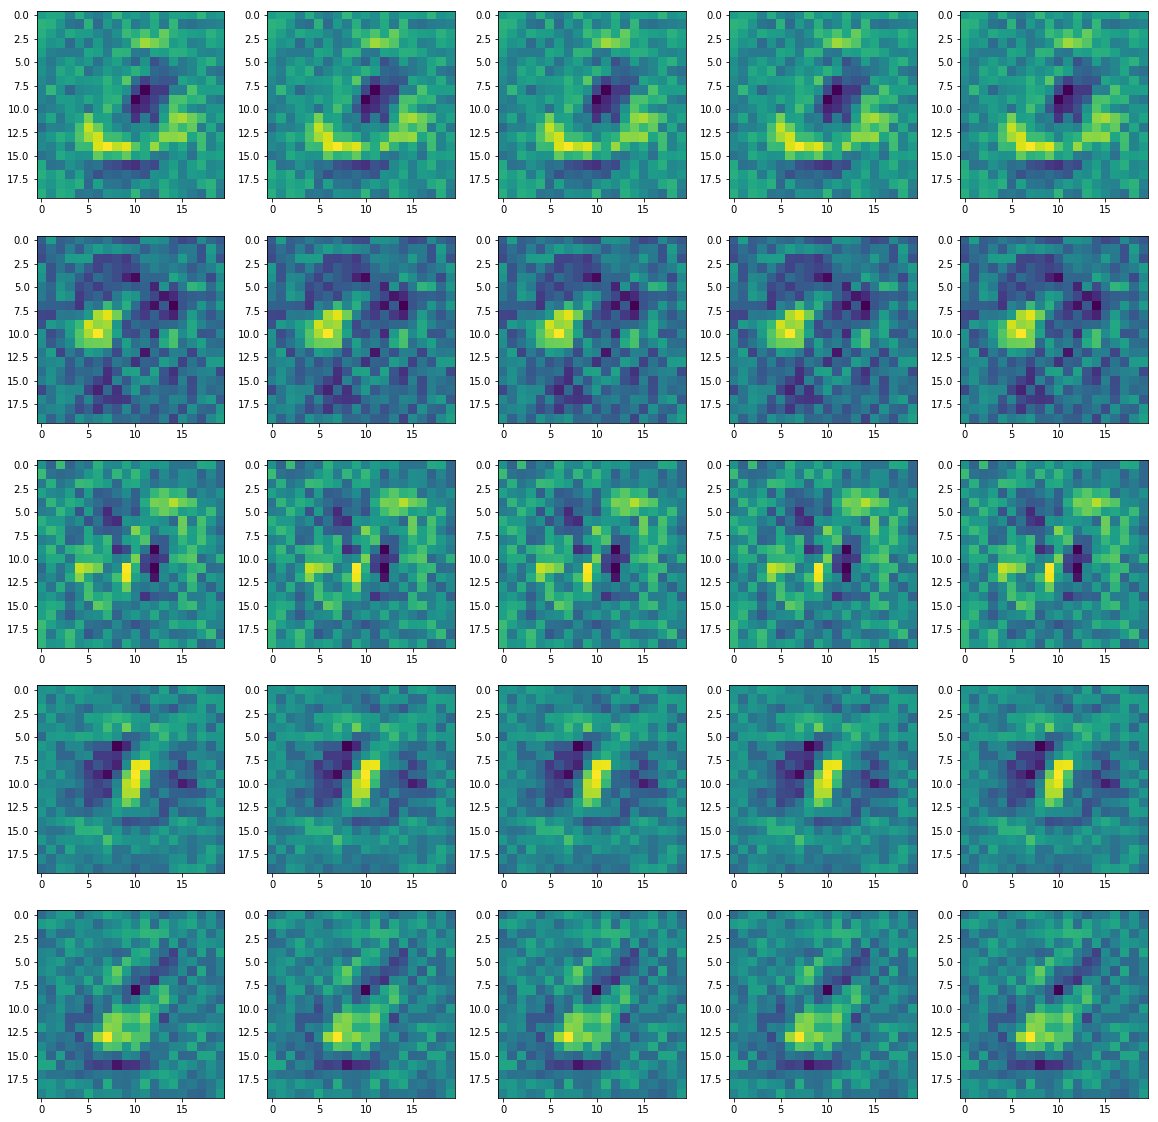

In [14]:
if (len(theta[0])%5) == 0:
    k = int(len(theta[0])/5)
else:
    k = int(len(theta[0])/5)+1

fig,axis = plt.subplots(k,5,figsize=(20,20))

for i in range(int(len(theta[0])/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(theta[0]):
            normal_theta = scalingMatrix(theta[0][i][1:])
            axis[i,j].imshow(normal_theta.reshape(20,20,order="F"))



In [36]:
pred = prediction(X, theta)
print("Training Set Accuracy", sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy 93.04 %


In [37]:
def wrongPred(pred,y):
    m = len(y)
    values = pd.DataFrame()
    for i in range(m):
        if (pred[i]-y[i])==0:
            pass
        else:
            if y[i]==10 and pred[i]==0:
                pass
            else:
                values = values.append(pd.DataFrame({'Indice':i,'Número real':y[i],'Número predito':pred[i]}))   
    values.index = range(1,len(values)+1)
    return values

df = wrongPred(pred,y)
df

,Indice,Número real,Número predito
1,71,10,8
2,101,10,5
3,112,10,3
4,124,10,6
5,142,10,8
6,261,10,6
7,265,10,4
8,316,10,3
9,329,10,6
10,351,10,7


In [38]:
# Plotting images with its actual number and wrong-predicted number

fig,axis = plt.subplots(int(len(df)/5)+1,5,figsize=(20,520))
for i in range(int(len(df)/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(df):
            axis[i,j].imshow(X[(df['Indice'][5*(i)+j+1]),:].reshape(20,20,order="F"))
            axis[i,j].set_title((df['Número real'][5*(i)+j+1],df['Número predito'][5*(i)+j+1]),size=20)
            axis[i,j].axis("off")
        else:
            break
plt.tight_layout()
#fig.suptitle('(Actual number, predicted number)',fontsize=16)



In [39]:
############## CHECK HOW TO SAVE TOPOLOGY OF NEWTORK AND FINAL THETA

### Same process using scipy

In [40]:
from scipy import optimize


In [41]:
# params = np.hstack((initial_theta[0].flatten(), initial_theta[1].flatten()))
# arg = (input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

# res = optimize.minimize(computeCost, params, args=arg, method='CG', options={'maxiter':100,'disp':True}, jac=True)


In [43]:
type(arg)

tuple

In [45]:
computeCost(X,y,initial_theta,input_layer_size, hidden_layer_size, num_labels, Lambda)

(0.5362823847689637,
 [array([[-1.09223812e-03,  0.00000000e+00,  0.00000000e+00, ...,
          -6.58108934e-08,  4.89725881e-09,  0.00000000e+00],
         [-7.46037142e-04,  0.00000000e+00,  0.00000000e+00, ...,
           4.42154988e-07, -4.74355968e-08,  0.00000000e+00],
         [ 1.17043437e-03,  0.00000000e+00,  0.00000000e+00, ...,
          -1.63244571e-07,  2.18959042e-08,  0.00000000e+00],
         ...,
         [ 3.65006254e-04,  0.00000000e+00,  0.00000000e+00, ...,
           4.82636321e-07, -5.75793178e-08,  0.00000000e+00],
         [ 4.45624558e-04,  0.00000000e+00,  0.00000000e+00, ...,
           1.42818519e-08,  3.46069913e-11,  0.00000000e+00],
         [-3.37231033e-04,  0.00000000e+00,  0.00000000e+00, ...,
           2.88087192e-08,  1.71483132e-09,  0.00000000e+00]]),
  array([[ 2.52334249e-04,  1.07620385e-04,  3.19234121e-04,
           3.15103211e-04,  4.51984980e-04, -8.62244202e-04,
          -1.33549026e-03, -7.67106516e-04, -1.23627404e-04,
           1